# EVENT SAMPLER TUTORIAL

## Prerequisites 

....

### Introduction

This tutorial describes how to  simulate an observation of a sky field, starting from a given IRF and a Sky model. The output of this process is the creation of a .fits photon event list. 
The core of the simulation lies into the Gammapy `MapDatasetEventSampler` class. The class bases its capabilities on the inverse cumulative distribution function (https://en.wikipedia.org/wiki/Cumulative_distribution_function#Inverse_distribution_function_(quantile_function)). 

The `MapDatasetEventSampler` takes in input a `Dataset` object from which it evaluates a map of predicted counts per bin and it then samples the events giving true coordinates, true energies and times of the events. The class then can also apply IRF corrections (i.e. the PSF and the energy dispersion) in order to reconstruct the coordinates and the energies of the sampled events. 

The metadata in the event-list are then catched from an `Observation` object. 


#### Minimal configuration

In [20]:
import numpy as np
import copy
import astropy.units as u
from astropy.coordinates import SkyCoord
from gammapy.data import GTI, Observation
from gammapy.datasets import MapDataset, MapDatasetEventSampler
from gammapy.maps import MapAxis, WcsGeom, Map
from gammapy.irf import load_cta_irfs
from gammapy.makers import MapDatasetMaker
from gammapy.modeling import Fit
from gammapy.modeling.models import (
    Model, Models, SkyModel, 
    PowerLawSpectralModel, 
    PointSpatialModel,
    GaussianSpatialModel
)
from regions import CircleSkyRegion

### Define the Sky model
First of all, let's define a Sky model for a point-like source centered at the Galactic Center and with a power-law spectral shape. We then save the model into a yaml file.

In [2]:
spectral_model = PowerLawSpectralModel(index=2,amplitude="1e-12 TeV-1 cm-2 s-1", reference='1 TeV')
spatial_model = PointSpatialModel(lon_0= "0 deg", lat_0="0 deg", frame='galactic')
sky_model = SkyModel(spectral_model=spectral_model, spatial_model=spatial_model)

models = Models([sky_model])

file_model = "point-pwl-time.yaml"
models.write(file_model, overwrite=True)

### Create the dataset
In this section we show how to create the dataset needed for the simulation. Here we adopt the IRF from the South configuration of the CTA DC1. We then set the pointing position of the simulation (0.5 deg off-axis from the source position) and an exposure time of 8 hr. 

The definition of the true and recostructed energy is important because the binning should be fine, at least 10 bins per decade....
The geometry of the dataset is a 4x4 deg^2, with a binsize of 0.02 deg...

In [3]:
IRF_FILE = "$GAMMAPY_DATA/cta-1dc/caldb/data/cta/1dc/bcf/South_z20_50h/irf_file.fits"

POINTING = SkyCoord(0.0, 0.5, frame="galactic", unit="deg")
LIVETIME = 8 * u.hr
GTI_TABLE = GTI.create(start=0 * u.s, stop=LIVETIME.to(u.s))

# dataset config
ENERGY_AXIS = MapAxis.from_energy_bounds("0.1 TeV", "100 TeV", nbin=10, per_decade=True)
ENERGY_AXIS_TRUE = MapAxis.from_energy_bounds("0.03 TeV", "300 TeV", nbin=20, per_decade=True, name="energy_true")
MIGRA_AXIS = MapAxis.from_bounds(0.5, 2, nbin=150, node_type="edges", name="migra")

WCS_GEOM = WcsGeom.create(
    skydir=POINTING, width=(4, 4), binsz=0.02, frame="galactic", axes=[ENERGY_AXIS]
)

The dataset is generated including also the background, the psf and the edisp..., and we write it into a file...

In [4]:
irfs = load_cta_irfs(IRF_FILE)
observation = Observation.create(
    obs_id=1001, pointing=POINTING, livetime=LIVETIME, irfs=irfs
)

empty = MapDataset.create(WCS_GEOM, energy_axis_true=ENERGY_AXIS_TRUE, migra_axis=MIGRA_AXIS)
maker = MapDatasetMaker(selection=["exposure", "background", "psf", "edisp"])
dataset = maker.run(empty, observation)

dataset.write('dataset.fits.gz', overwrite=True)

### Simulate the source + background events

To simulate the Sky model, we need to provide the Sky model to the dataset:

In [5]:
dataset.models.extend(models)
print(dataset.models)

Models

Component 0: BackgroundModel

  Name                      : h4lEqBgo-bkg
  Datasets names            : ['h4lEqBgo']
  Parameters:
    norm                    :   1.000              
    tilt         (frozen)   :   0.000              
    reference    (frozen)   :   1.000  TeV         

Component 1: SkyModel

  Name                      : Ooxqmw3V
  Datasets names            : None
  Spectral model type       : PowerLawSpectralModel
  Spatial  model type       : PointSpatialModel
  Temporal model type       : None
  Parameters:
    lon_0                   :   0.000  deg         
    lat_0                   :   0.000  deg         
    index                   :   2.000              
    amplitude               :   1.00e-12  1 / (cm2 s TeV)
    reference    (frozen)   :   1.000  TeV         




We then create an `Observation` object, from which the event-sampler will take the meta-data to be written in the ouput event list...

In [6]:
obs_id=1
observation = Observation.create(
    obs_id=obs_id, pointing=POINTING, livetime=LIVETIME, irfs=irfs
)

The next step shows how to sample the events with the `MapdatasetEventSampler` class. The class requests a random number seed generator that we set with `random_state=0`. 

In [7]:
sampler = MapDatasetEventSampler(random_state=0)
events = sampler.run(dataset, observation)

The output of the event-sampler is an event list with coordinates, energies and time of arrivals of the source and background events. Source and background events are flagged by the MC_ID identifier (0 for the background and 2 for the source).

In [8]:
events.table

ENERGY,RA,DEC,TIME,MC_ID,ENERGY_TRUE,RA_TRUE,DEC_TRUE,EVENT_ID
TeV,deg,deg,s,,TeV,deg,deg,
float64,float64,float64,float64,int64,float64,float64,float64,int64
0.11800801694552371,266.1009570674052,-28.434981474251984,16955.57116137352,0,--,--,--,0
0.1239162178758761,266.89271437906126,-30.135395867297287,3530.147193954326,0,--,--,--,1
0.17344350504583347,267.17018139428404,-29.593065821769315,20781.491837161593,0,--,--,--,2
0.13301654784528003,266.52891942106265,-31.11508730920255,2524.6637854725122,0,--,--,--,3
0.2476203786575189,265.97388052149313,-28.52486556849605,2253.3750782953575,0,--,--,--,4
0.22280240126369782,264.1675253640174,-28.125491182071933,1441.690453933552,0,--,--,--,5
0.10946650074654574,268.0938747764816,-28.521589455591823,8124.263406917453,0,--,--,--,6
0.3072529355476383,268.6388919244759,-28.275881083938966,9173.462255462073,0,--,--,--,7


In [9]:
print(f"Source events: {len(np.where(events.table['MC_ID']==2)[0])}")
print(f"Background events: {len(np.where(events.table['MC_ID']==0)[0])}")

Source events: 1703
Background events: 365554


In [10]:
events.table.write("events_0001.fits.gz", overwrite=True)

### Generate a skymap
A skymap of the simulated events is the following:

(<Figure size 432x288 with 2 Axes>,
 <matplotlib.colorbar.Colorbar at 0x1233ade80>)

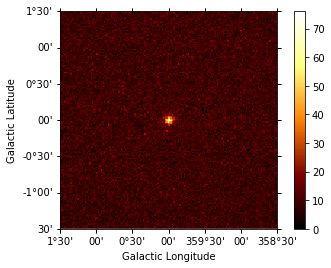

In [11]:
counts = Map.create(frame="galactic", skydir=(0, 0.), binsz=0.02, npix=(150, 150))
counts.fill_events(events)
counts.plot(add_cbar=True)

### Fit the simulated data
We can now check the sake of the event sampling by fitting the data with the same Sky model adopted for the simulation. Hence, we firstly read the dataset and the model file, and we fill the dataset with the events.

In [12]:
dataset = MapDataset.read("dataset.fits.gz")
models = Models.read("point-pwl-time.yaml")

counts = Map.from_geom(WCS_GEOM)
counts.fill_events(events)
dataset.counts = counts
dataset.models.extend(models)

Let's fit the data and look at the results:

In [13]:
fit = Fit([dataset])

In [14]:
result = fit.run(optimize_opts={"print_level": 1})
dataset.models.write("best-fit_model.yaml", overwrite=True)
covariance = result.parameters.get_subcovariance(models.parameters)
np.savetxt("covariance.txt", covariance)
print(result)

------------------------------------------------------------------
| FCN = 6.793E+05               |     Ncalls=121 (121 total)     |
| EDM = 8.07E-06 (Goal: 1E-05)  |            up = 1.0            |
------------------------------------------------------------------
|  Valid Min.   | Valid Param.  | Above EDM | Reached call limit |
------------------------------------------------------------------
|     True      |     True      |   False   |       False        |
------------------------------------------------------------------
| Hesse failed  |   Has cov.    | Accurate  | Pos. def. | Forced |
------------------------------------------------------------------
|     False     |     True      |   True    |   True    | False  |
------------------------------------------------------------------
OptimizeResult

	backend    : minuit
	method     : minuit
	success    : True
	message    : Optimization terminated successfully.
	nfev       : 121
	total stat : 679267.17



In [19]:
result.parameters.to_table()

name,value,error,unit,min,max,frozen
str9,float64,float64,str14,float64,float64,bool
norm,1.002e+00,1.659e-03,,0.000e+00,nan,False
tilt,0.000e+00,0.000e+00,,nan,nan,True
reference,1.000e+00,0.000e+00,TeV,nan,nan,True
lon_0,-1.133e-03,1.253e-03,deg,nan,nan,False
lat_0,-6.950e-04,1.268e-03,deg,-9.000e+01,9.000e+01,False
index,1.997e+00,2.289e-02,,nan,nan,False
amplitude,1.015e-12,3.496e-14,cm-2 s-1 TeV-1,nan,nan,False
reference,1.000e+00,0.000e+00,TeV,nan,nan,True


The results are quite satisfactory and consistent with the simulated parameters within ~1 sigma.

### Residual map
Finally, we can generate a residual map to ...

(<matplotlib.axes._subplots.WCSAxesSubplot at 0x1247f5cc0>,
 <matplotlib.axes._subplots.AxesSubplot at 0x12041da20>)

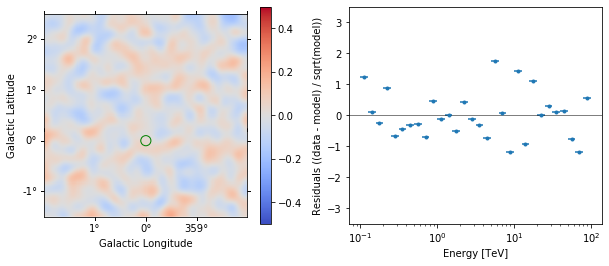

In [16]:
model = dataset.models[1]
spatial_model = model.spatial_model
region = CircleSkyRegion(center=spatial_model.position, radius=0.1 * u.deg)
dataset.plot_residuals(method="diff/sqrt(model)", vmin=-0.5, vmax=0.5, region=region, figsize=(10, 4))

### Extended source

In [21]:
spectral_model = PowerLawSpectralModel(index=2,amplitude="1e-12 TeV-1 cm-2 s-1", reference='1 TeV')
spatial_model = GaussianSpatialModel(lon_0= "0 deg", lat_0="0 deg", sigma="0.3 deg", frame='galactic')
sky_model = SkyModel(spectral_model=spectral_model, spatial_model=spatial_model)

models = Models([sky_model])

file_model = "gauss-pwl-time.yaml"
models.write(file_model, overwrite=True)

In [22]:
dataset = MapDataset.read("dataset.fits.gz")
dataset.models.extend(models)
print(dataset.models)

Models

Component 0: BackgroundModel

  Name                      : BXemg_od
  Datasets names            : ['X3J1B3sE']
  Parameters:
    norm                    :   1.000              
    tilt         (frozen)   :   0.000              
    reference    (frozen)   :   1.000  TeV         

Component 1: SkyModel

  Name                      : PqfBKSYb
  Datasets names            : None
  Spectral model type       : PowerLawSpectralModel
  Spatial  model type       : GaussianSpatialModel
  Temporal model type       : None
  Parameters:
    lon_0                   :   0.000  deg         
    lat_0                   :   0.000  deg         
    sigma                   :   0.300  deg         
    e            (frozen)   :   0.000              
    phi          (frozen)   :   0.000  deg         
    index                   :   2.000              
    amplitude               :   1.00e-12  1 / (cm2 s TeV)
    reference    (frozen)   :   1.000  TeV         




In [23]:
sampler = MapDatasetEventSampler(random_state=0)
events = sampler.run(dataset, observation)

(<Figure size 432x288 with 2 Axes>,
 <matplotlib.colorbar.Colorbar at 0x12d628cc0>)

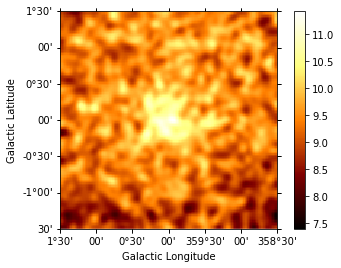

In [34]:
counts = Map.create(frame="galactic", skydir=(0, 0.), binsz=0.02, npix=(150, 150))
counts.fill_events(events)
counts.smooth(0.05 * u.deg).plot(add_cbar=True)

In [35]:
dataset = MapDataset.read("dataset.fits.gz")
models = Models.read("gauss-pwl-time.yaml")

counts = Map.from_geom(WCS_GEOM)
counts.fill_events(events)
dataset.counts = counts
dataset.models.extend(models)

In [37]:
fit = Fit([dataset])
result = fit.run(optimize_opts={"print_level": 1})
print(result)

------------------------------------------------------------------
| FCN = 6.833E+05               |     Ncalls=155 (155 total)     |
| EDM = 0.00012 (Goal: 1E-05)   |            up = 1.0            |
------------------------------------------------------------------
|  Valid Min.   | Valid Param.  | Above EDM | Reached call limit |
------------------------------------------------------------------
|     True      |     True      |   False   |       False        |
------------------------------------------------------------------
| Hesse failed  |   Has cov.    | Accurate  | Pos. def. | Forced |
------------------------------------------------------------------
|     False     |     True      |   True    |   True    | False  |
------------------------------------------------------------------
OptimizeResult

	backend    : minuit
	method     : minuit
	success    : True
	message    : Optimization terminated successfully.
	nfev       : 155
	total stat : 683268.49



In [38]:
result.parameters.to_table()

name,value,error,unit,min,max,frozen
str9,float64,float64,str14,float64,float64,bool
norm,9.994e-01,1.693e-03,,0.000e+00,nan,False
tilt,0.000e+00,0.000e+00,,nan,nan,True
reference,1.000e+00,0.000e+00,TeV,nan,nan,True
lon_0,2.352e-03,2.284e-02,deg,nan,nan,False
lat_0,7.063e-03,2.209e-02,deg,-9.000e+01,9.000e+01,False
sigma,2.817e-01,1.512e-02,deg,0.000e+00,nan,False
e,0.000e+00,0.000e+00,,0.000e+00,1.000e+00,True
phi,0.000e+00,0.000e+00,deg,nan,nan,True
index,2.005e+00,4.383e-02,,nan,nan,False


(<matplotlib.axes._subplots.WCSAxesSubplot at 0x123ec2908>,
 <matplotlib.axes._subplots.AxesSubplot at 0x124363978>)

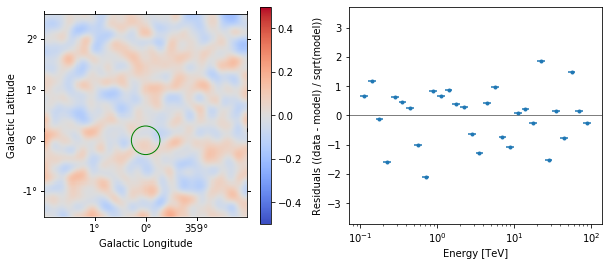

In [40]:
model = dataset.models[1]
spatial_model = model.spatial_model
region = spatial_model.to_region()
dataset.plot_residuals(method="diff/sqrt(model)", vmin=-0.5, vmax=0.5, region=region, figsize=(10, 4))

### Exercise
- Change the spatial model and the spectrum of the simulated Sky model;
- Include a temporal model in the simulation